# CSCA5642 Final Project 
## Introduction
### Problem Statement

The goal of this project is to build a **search query engine** that returns relevant **songs based on a user’s input phrase, mood, or "vibe"**. Instead of relying on metadata like genre or artist, the engine will **analyze the lyrics** and find songs whose content aligns semantically or emotionally with the user’s input.

This is especially useful for:
- Discovering songs with **similar themes or emotional tone**
- Curating playlists based on **mood, situation, or ideas**
- Enabling a **more expressive and intuitive way to search** for music

To achieve this, I will use **Natural Language Processing (NLP)** techniques to embed both the query and the lyrics into a shared semantic space, allowing for meaningful comparison.

---

### Dataset Overview

I’m using the **Genius Song Lyrics** dataset:

Here’s a quick summary of the dataset:

- **Number of rows**: 5,134,856
- **Number of unique songs**: 3,093,216
- **Number of unique artists**: 641,349
- **Columns**:
  - `title`: Title of the piece. Most entries are songs, but there are also some books, poems and even some other stuff
  - `tag`: 	Genre of the piece. Most non-music pieces are "misc", but not all. Some songs are also labeled as "misc"
  - `artist`: Person or group the piece is attributed to
  - `year`: Release year
  - `views`: Number of page views
  - `features`: Other artists that contributed
  - `lyrics`: Lyrics
  - `id`: Genius identifier
  - `language_cld3`: Lyrics language according to CLD3. Not reliable results are NaN
  - `language_ft`: Lyrics language according to FastText's langid. Values with low confidence (<0.5) are NaN
  - `language`: Combines language_cld3 and language_ft. Only has a non NaN entry if they both "agree"

This dataset provides a large and diverse set of lyrics in multiple languages, enabling the creation of a model that can work across different styles and cultural contexts.

In [1]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("carlosgdcj/genius-song-lyrics-with-language-information")

print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/genius-song-lyrics-with-language-information


In [2]:
#Load Dataset
import pandas as pd
df = pd.read_csv("/kaggle/input/genius-song-lyrics-with-language-information/song_lyrics.csv")

In [3]:
#Print number of rows and first 5 rows
print(f"Row count: {len(df)}")
print(df.head())
print(df.columns)

#Print number of unique songs and artists in dataframe
print(f"Number of unique songs in the dataset: {df['title'].nunique()}")
print(f"Number of unique artists in the dataset: {df['artist'].nunique()}")

Row count: 5134856
               title  tag     artist  year   views  \
0          Killa Cam  rap    Cam'ron  2004  173166   
1         Can I Live  rap      JAY-Z  1996  468624   
2  Forgive Me Father  rap   Fabolous  2003    4743   
3       Down and Out  rap    Cam'ron  2004  144404   
4             Fly In  rap  Lil Wayne  2005   78271   

                                       features  \
0                   {"Cam\\'ron","Opera Steve"}   
1                                            {}   
2                                            {}   
3  {"Cam\\'ron","Kanye West","Syleena Johnson"}   
4                                            {}   

                                              lyrics  id language_cld3  \
0  [Chorus: Opera Steve & Cam'ron]\nKilla Cam, Ki...   1            en   
1  [Produced by Irv Gotti]\n\n[Intro]\nYeah, hah,...   3            en   
2  Maybe cause I'm eatin\nAnd these bastards fien...   4            en   
3  [Produced by Kanye West and Brian Miller]\n\n[... 

## Exploratory Data Analysis (EDA)

### 1. Initial Dataset Exploration

Initial exploration steps:

- **Shape of the dataset** was printed to determine the number of rows and columns. The dataset contained 5,134,856 rows and 11 columns.
- **Missing values** were identified.
- Rows missing the **`title`** column were dropped to ensure each entry had a valid identifier. There were 118 rows that were missing a **`title`** .

---

### 2. Language Filtering and Cleaning

To ensure accurate analysis and meaningful results from semantic search:

- Rows where **all three language columns** (`language`, `language_cld3`, `language_ft`) were null were removed.
- Retained only rows where **both language detectors** (`language_cld3` and `language_ft`) identified the lyrics as **English (`'en'`)**.
- After filtering, the helper language columns (`language_cld3` and `language_ft`) were dropped to avoid redundancy.


---

### 3. Genre Distribution

We visualized the most common genres in the dataset using a bar plot:

- **Genres** are captured in the `tag` column.
- The bar chart shows the number of songs per genre. The two genres were pop and rap. 

This helps identify which musical styles dominate the dataset.

---

### 4. Song Release Years

The `year` column was:

- Converted to numeric.
- Cleaned of invalid values.
- Used to plot a histogram showing the distribution of song releases over time.
- Theres seems to be some mess in the dataset due to the minimum value being 1 and the maximum value being 2100. Fortunatley, this column is not too important for the datset, but will be unchanged for now since it could allow for useful analysis in the future.  

The bin width was dynamically calculated based on the range between min and max years to maintain scalability.

This chart helps analyze how song data spans across decades and observe any trends.

---

### 5. Lyrics Length Analysis

We created a new feature: **`lyrics_length`** (number of characters in each song's lyrics).

Visualized using:

- **Histogram**: to examine the general distribution of lyric lengths.
- **Boxplot**: to identify outliers and see the range of song verbosity.

This step is useful for detecting outliers and preparing for downstream processing like embedding or sequence modeling. This distrubution is skewed to the right with several outliers with a large lyric length.

---

### 6. Correlation Matrix

We analyzed correlations between the following numeric features:

- `year`
- `lyrics_length`
- `views`

The correlation heatmap helps detect any potential linear relationships between features.

**Findings**:

- Minimal correlation between song views and lyrics length.
- Weak to no correlation between song year and other numeric variables.
  
---

### 7. Lyrics Cleaning for NLP & Semantic Search

A custom text cleaning function was applied to the `lyrics` column to prepare it for **semantic search** using models like **SBERT** or **BERT**. The following steps were performed:

- Converted all text to lowercase for normalization.
- Removed section markers such as `[Chorus]`, `[Verse 1]`, and parentheses like `(Repeat)`.
- Removed unnecessary special characters while **preserving meaningful punctuation** (`.`, `!`, `?`, `'`) to retain sentence structure.
- Removed URLs if present.
- Normalized repeated punctuation (e.g., `"!!!"` → `"!"`) and extra whitespaces.

These steps ensure the text remains **semantically rich and structurally intact**, improving the quality of **sentence embeddings** and thus the relevance of search results in the final engine.

---

### 8. Feature Cleaning for Semantic Search

A custom text cleaning function was applied to the `features` column to standardize and parse the data for **semantic search** models. The following steps were performed:

- **Handled missing or empty entries** by returning an empty set if the value was `NaN` or empty.
- **Removed unnecessary characters**: The string was stripped of curly braces (`{}`) and single quotes (`'`) that may have been present due to the data format.
- **Split the string** by commas to extract individual contributors, allowing for better granularity in the data.
- **Whitespace normalization**: Extra spaces around contributors were removed to ensure clean and consistent data.

These cleaning steps ensure that the **features** data is **well-structured and consistent**, making it easier for the **semantic search engine** to identify relationships and match queries accurately based on the cleaned features.

---

### Summary of Findings

- **Language Filtering** was necessary to maintain consistency in English-only lyrics.
- **Genre Distribution** shows diversity in lyrical themes across music styles.
- **Song Release Dates** span a wide range, offering historical insight into lyrical trends.
- **Lyrics Length** varies significantly, which could affect model training or embedding performance.
- **Text Cleaning** ensures input data is suitable for downstream semantic modeling.


In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# For text preprocessing
import numpy as np
import re

# Settings
sns.set(style="whitegrid")
plt.rcParams["figure.figsize"] = (12, 6)


# Basic Info
print("Shape of dataset:", df.shape)
print("\nColumn Info:\n")
print(df.info())
print("\nMissing Values:\n")
print(df.isnull().sum())

df_clean = df.dropna(subset=['title'])



Shape of dataset: (5134856, 11)

Column Info:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5134856 entries, 0 to 5134855
Data columns (total 11 columns):
 #   Column         Dtype 
---  ------         ----- 
 0   title          object
 1   tag            object
 2   artist         object
 3   year           int64 
 4   views          int64 
 5   features       object
 6   lyrics         object
 7   id             int64 
 8   language_cld3  object
 9   language_ft    object
 10  language       object
dtypes: int64(3), object(8)
memory usage: 430.9+ MB
None

Missing Values:

title               188
tag                   0
artist                0
year                  0
views                 0
features              0
lyrics                0
id                    0
language_cld3     90966
language_ft      134322
language         226918
dtype: int64


In [5]:
# Remove rows where there is no confidence with language
print(f"Number of rows null in all three language columns: {len(df_clean[(df_clean['language_cld3'].isnull()) & (df_clean['language_ft'].isnull()) & (df_clean['language'].isnull())])}")
df_clean = df_clean[~(
    df_clean['language_cld3'].isnull() & 
    df_clean['language_ft'].isnull() & 
    df_clean['language'].isnull()
)]

##at least one has to be english
df_clean = df_clean[
    (df_clean['language_cld3'] == 'en') | (df_clean['language_ft'] == 'en')
]

## see if any dont aggree
non_null_langs = df_clean.dropna(subset=['language_cld3', 'language_ft'])
mismatched_langs = non_null_langs[
    (non_null_langs['language_cld3'] != non_null_langs['language_ft'])]
print(f"Number of rows with conflicting language values: {len(mismatched_langs)}")
print(mismatched_langs.head())

df_clean = df_clean[
    (df_clean['language_cld3'] == 'en') & (df_clean['language_ft'] == 'en')
]

print(f"Number of rows after filtering by language: {len(df_clean)}")

mismatched_langs = df_clean[
    (df_clean['language_cld3'] != df_clean['language_ft']) |
    (df_clean['language_cld3'] != df_clean['language']) |
    (df_clean['language_ft'] != df_clean['language'])
]

print(f"New number of rows after that differ in language columns: {len(mismatched_langs)}")

df_clean = df_clean.drop(columns=['language_ft', 'language_cld3'])

Number of rows null in all three language columns: 39817
Number of rows with conflicting language values: 14845
                     title  tag        artist  year   views  \
1216                 Voila  pop  Radio Killer  2009    1567   
3683   Shadows of Tomorrow  rap    Madvillain  2004  125498   
14412          Break It Up  rap  Cypress Hill  1991    1021   
15544   Long Island Wildin  rap    De La Soul  1993    3538   
15603           Stickabush  rap    De La Soul  2011     233   

                                    features  \
1216                                      {}   
3683                             {Quasimoto}   
14412                                     {}   
15544  {"高木完 (Kan Takagi)","Scha Dara Parr"}   
15603                                     {}   

                                                  lyrics     id language_cld3  \
1216   Voila, la la la c'est la\nVoila, la la la c'es...   1201            en   
3683   [Produced by Madlib]\n\n[Intro]\n"誰砍倒了櫻桃樹"\n\n...  

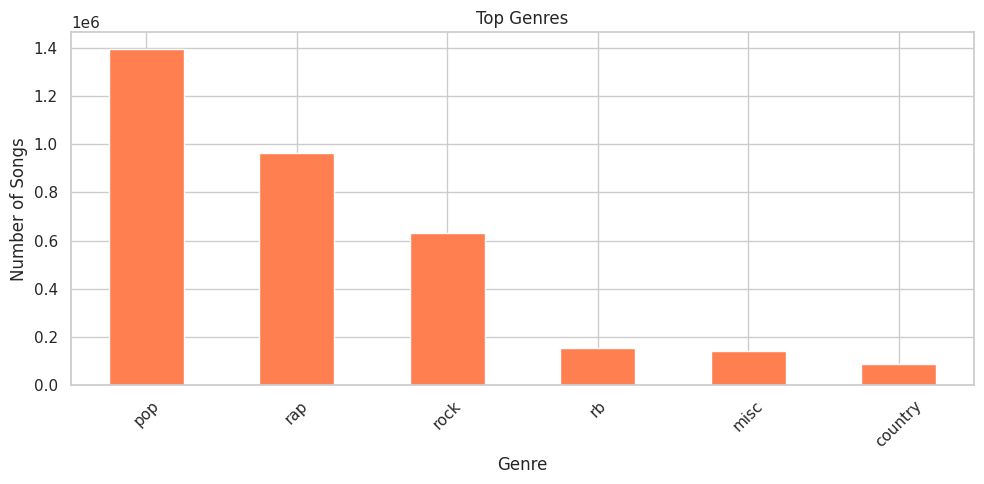

Min year: 1
Max year: 2100


/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


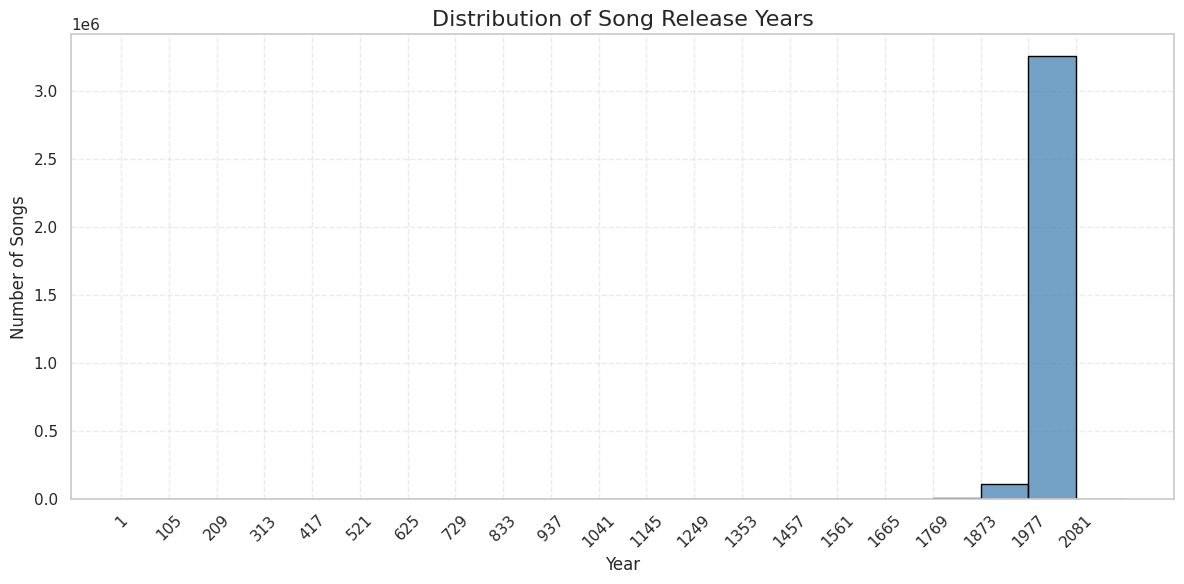

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


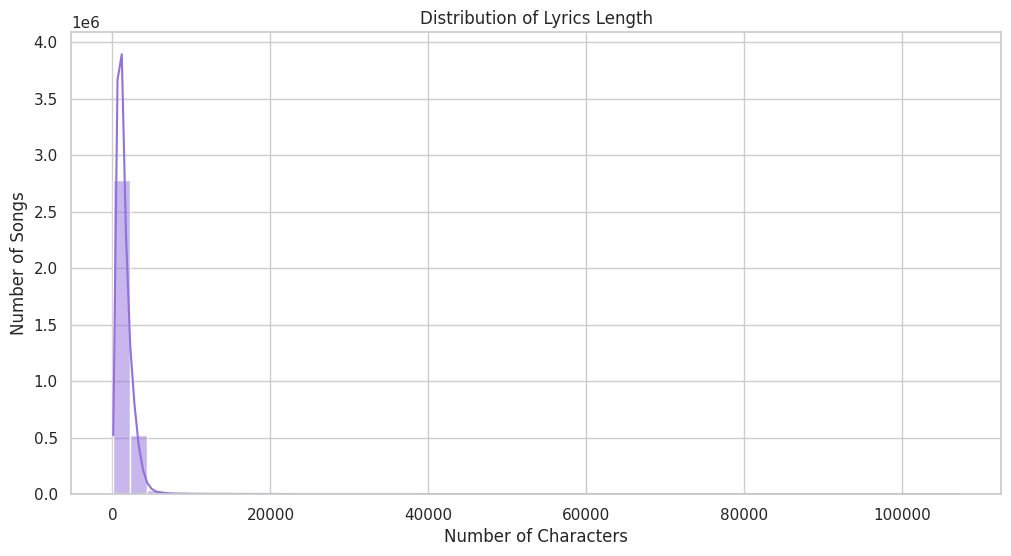

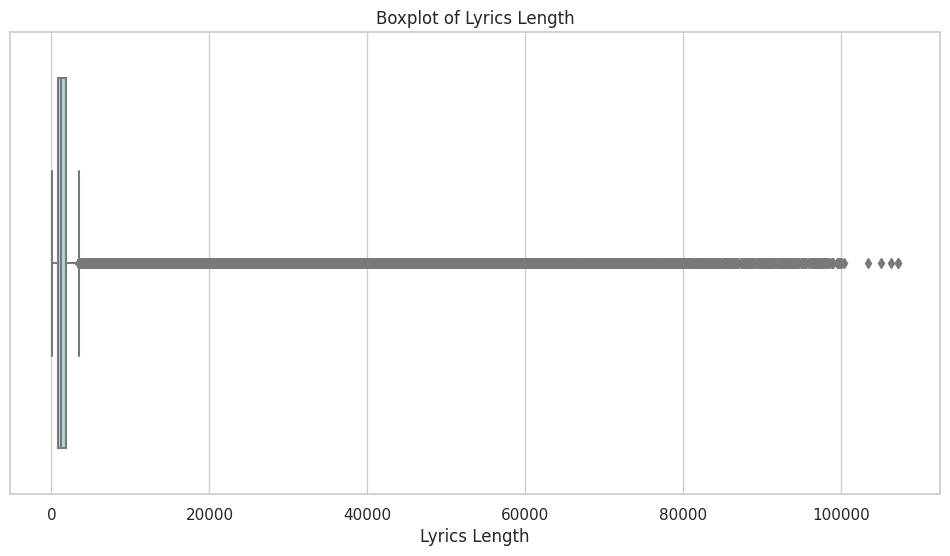

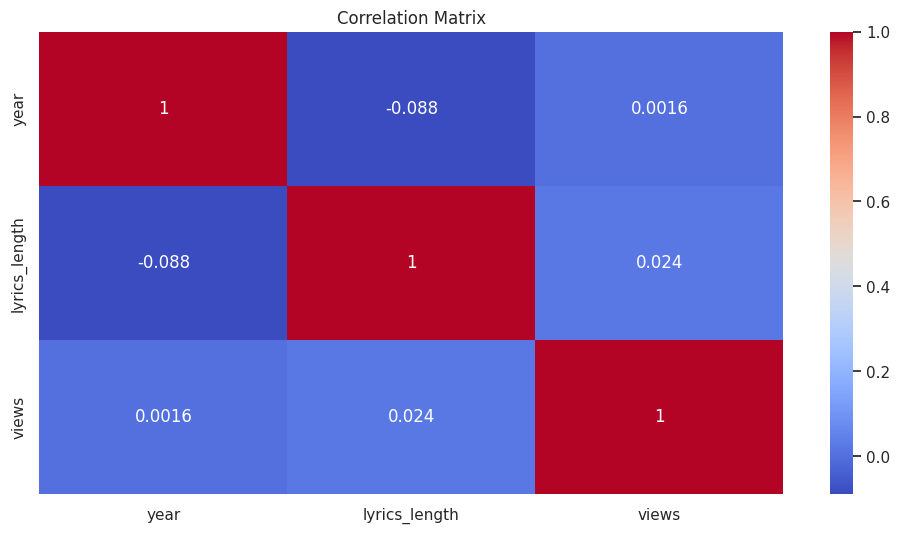

In [6]:
# 📊 Song Counts by Genre
plt.figure(figsize=(10, 5))
df_clean['tag'].value_counts().plot(kind='bar', color='coral')
plt.title("Top Genres")
plt.xlabel("Genre")
plt.ylabel("Number of Songs")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Auto-detect min and max year

min_year = int(df_clean['year'].min())
max_year = int(df_clean['year'].max())
print(f"Min year: {min_year}")
print(f"Max year: {max_year}")

# Dynamically set bin count (e.g. 1 bin per 5 years, or capped at 20 bins)
year_range = max_year - min_year
bin_step = max(1, year_range // 20)
bins = np.arange(min_year, max_year + bin_step, bin_step)

# Plot Songs over yeat dynamically
plt.figure(figsize=(12, 6))
sns.histplot(df_clean['year'], bins=bins, color='steelblue', edgecolor='black')

plt.title("Distribution of Song Release Years", fontsize=16)
plt.xlabel("Year", fontsize=12)
plt.ylabel("Number of Songs", fontsize=12)
plt.xticks(np.arange(min_year, max_year + 1, bin_step), rotation=45)
plt.grid(True, linestyle='--', alpha=0.4)
plt.tight_layout()
plt.show()


# 📏 Lyrics Length Distribution
df_clean['lyrics_length'] = df_clean['lyrics'].astype(str).apply(len)

plt.figure()
sns.histplot(df_clean['lyrics_length'], bins=50, kde=True, color='mediumpurple')
plt.title("Distribution of Lyrics Length")
plt.xlabel("Number of Characters")
plt.ylabel("Number of Songs")
plt.show()

# 📉 Check for Outliers in Lyrics Length
plt.figure()
sns.boxplot(x=df_clean['lyrics_length'], color='lightblue')
plt.title("Boxplot of Lyrics Length")
plt.xlabel("Lyrics Length")
plt.show()

# 🔄 Correlation Matrix (for numeric columns)
numeric_cols = ['year', 'lyrics_length', 'views']
correlation = df_clean[numeric_cols].corr()

sns.heatmap(correlation, annot=True, cmap="coolwarm")
plt.title("Correlation Matrix")
plt.show()


In [7]:
del df  # or whatever your DataFrame is named
import gc
gc.collect()
def clean_lyrics(text):
    if pd.isnull(text):
        return ""

    # Lowercase for normalization
    text = text.lower()

    # Remove text inside brackets (like [Chorus], [Verse 1])
    text = re.sub(r'\[.*?\]', '', text)

    # Remove text inside parentheses (like (repeat), (2x)) if present
    text = re.sub(r'\(.*?\)', '', text)

    # Remove URLs if any (not common in lyrics, but safe to include)
    text = re.sub(r'https?://\S+|www\.\S+', '', text)

    # Keep only relevant punctuation (.,!?') and remove the rest
    # BERT can handle these, and they add sentence structure
    text = re.sub(r"[^a-zA-Z0-9\s\.\,\!\?']", '', text)

    # Normalize repeated punctuation (e.g., "!!!", "??") to a single mark
    text = re.sub(r'([!?.]){2,}', r'\1', text)

    # Normalize whitespace
    text = re.sub(r'\s+', ' ', text).strip()

    return text

# Apply cleaning to the lyrics column
df_clean['clean_lyrics'] = df_clean['lyrics'].apply(clean_lyrics)

In [8]:
def clean_features(features):
    """
    Clean and parse the features column to get individual contributors.
    """
    # If the entry is not NaN or empty
    if pd.isnull(features) or features.strip() == "":
        return set()
    
    # Clean the string to get rid of any extra spaces, special characters, etc.
    features_clean = features.strip("{}").replace("'", "").split(",")
    
    # Return as a set for easy comparison
    return set(f.strip() for f in features_clean)

# Apply cleaning to the features column (assuming df_clean is your dataframe)
df_clean['clean_features'] = df_clean['features'].apply(clean_features)


In [17]:
df_clean.to_csv('df_clean_output.csv', index=False)